<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Отток клиентов

Из банка стали уходить клиенты. 

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры (более 0.59).

Дополнительно измеряем *AUC-ROC*, сравниваем её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

**Импортируем библиотеки**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)

                             
from sklearn.utils import shuffle


import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# константа
RANDOM_STATE = 12345

In [2]:
# установим последнюю версию scikit-learn
!pip install scikit-learn==1.1.3

**Считаем данные из csv-файла в датафрейм и сохраним в переменную data. Путь к файлу:**
`/datasets/Churn.csv`

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

**Выводим первые 10 строчек датафрейма на экран**

In [4]:
pd.set_option('display.max_columns', None)
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


**Описание данных**

**Признаки**
- **RowNumber** — индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — сколько лет человек является клиентом банка
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты (1 - есть кредитная карта, 0 - нет кредитной карты)
- **IsActiveMember** — активность клиента (1- активен, 0 - не активен)
- **EstimatedSalary** — предполагаемая зарплата

**Целевой признак**
- **Exited** — факт ухода клиента ( 1 - ушел клиент, 0 - не ушел)

**Выведим основную информацию о датафрейме.**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В таблице 14 столбцов и 10000 строк.

Кол-во значений одинаково во всех столбцах кроме **Tenure**. Необходимо будет исследовать пропущенные значения в данном столбце. Также значения в столбцах **Tenure**  вероятно не соовтесвуют своему типу данных (так под кол-вом лет подразумевается целое число). Предлагается перевести в целочисленный тип `int64`. Но прежде чем переводить необходимо разобраться в причине пропусков и их устарнить

**Посчитаем какой процент от всего датафрейма составляют пропуски.**

In [6]:
print('Процент пропусков в столбце Tenure:',(data['Tenure'].isna().sum()/len(data))*100, '%')
print('Кол-во пропусков в столбце Tenure:',(data['Tenure'].isna().sum()))

Процент пропусков в столбце Tenure: 9.09 %
Кол-во пропусков в столбце Tenure: 909


Пропуски составляют 9%. Достаточно много, чтобы их сразу удалить. Необходимо провести анализ. Вдруг есть какая-то зависимсоть.

**Построим гистограмму распределения значений в столбце Tenure**

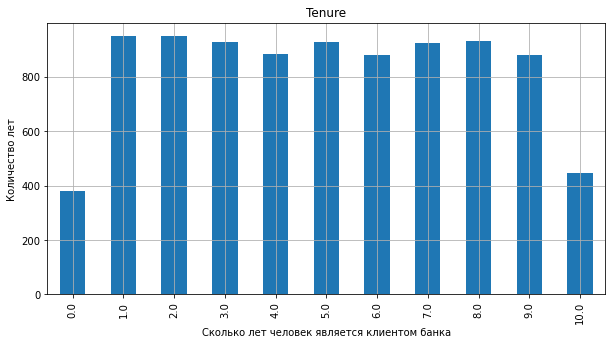

In [7]:
(data.groupby('Tenure')['Tenure']
 .count()
 .plot(kind='bar',
       figsize=(10,5),
      grid = True)
)
plt.title('Tenure')
plt.xlabel('Сколько лет человек является клиентом банка')
plt.ylabel('Количество лет')
plt.show()

In [8]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

По гистограмме можно наблюдать, что в базе кол-во клиентов равномерно распределено по длительности пользования услуг банка. Наблюдаются резкий спад на значение 0 и 10, но кол-во лет между собой не сильно отличаается.

**Построим гистограмму распределения значений в столбце Tenure, но заполним временно пустые строеки значением unknown** 

In [9]:
data_copy = data.copy()

In [10]:
data_copy['Tenure'] = data_copy['Tenure'].fillna('unknown')

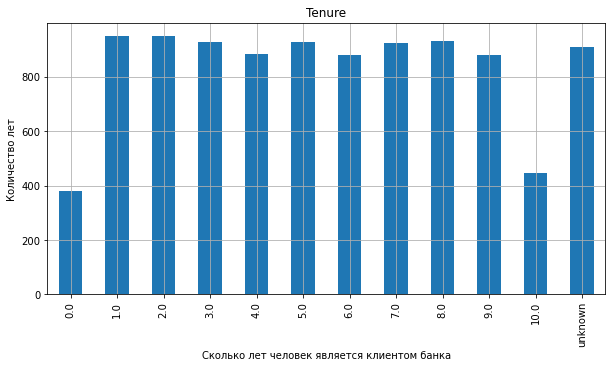

In [11]:
(data_copy.groupby('Tenure')['Tenure']
 .count()
 .plot(kind='bar',
       figsize=(10,5),
      grid = True)
)
plt.title('Tenure')
plt.xlabel('Сколько лет человек является клиентом банка')
plt.ylabel('Количество лет')
plt.show()

Можно наблюдать, что столбец unknown приблизительно соответсвует остальным столбцам графика. 

**Посмотрим как распределны по категориям 'Gender', 'Geography','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited' пустые и заполненные значения в 'Tenure'**

In [12]:
def sravnenie(a):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)


    (data[data['Tenure'].isna() == False]
     .groupby(a)[a]
     .count()
     .plot(kind='bar',
           grid = True,
           ax=axes[0]
          )
    )
    axes[0].set_title("Заполненные значение в Tenure");
    axes[0].set_ylabel('Количество')


    (data[data['Tenure'].isna() == True]
     .groupby(a)[a]
     .count()
     .plot(kind='bar',
           ax=axes[1],
           grid = True)
    )
    axes[1].set_title("Пустые значение в Tenure");
    axes[1].set_ylabel('Количество')
    plt.show()
    return

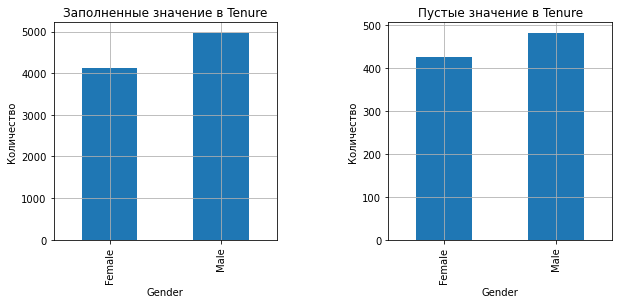

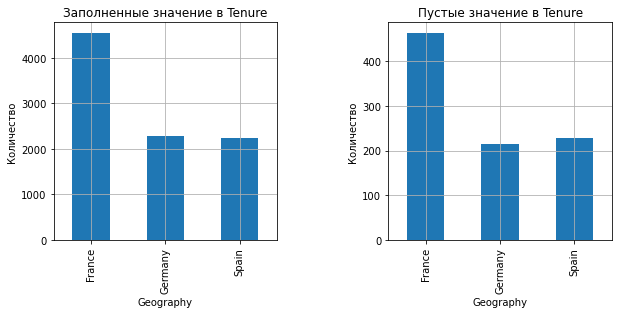

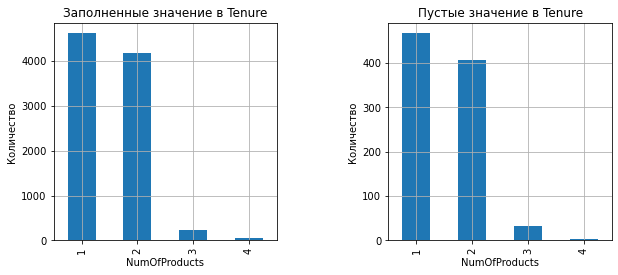

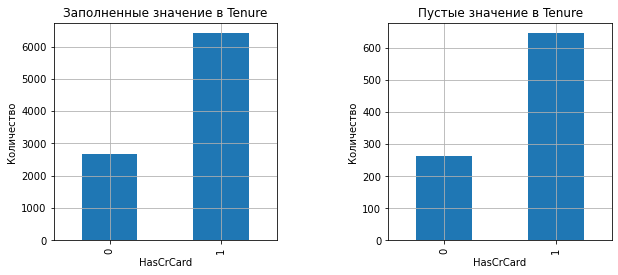

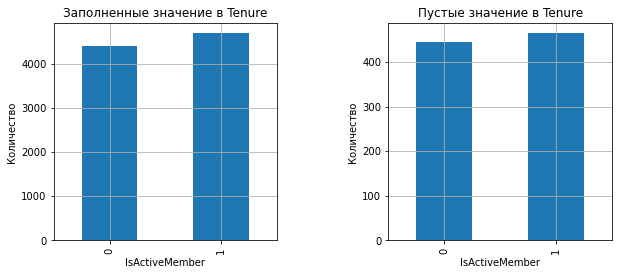

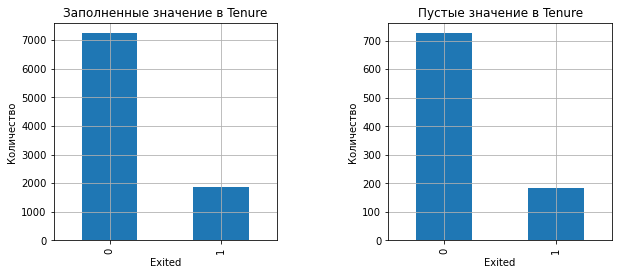

In [13]:
for i in ['Gender', 'Geography','NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    sravnenie(i)

Наблюдается неравномерное распредление данных в 'Geography','NumOfProducts', 'HasCrCard', 'Exited'

Во всех случаях между значениями пропущенными и заполненными наблюдается прямая пропорциональность по каждой категории. Таким образом пропущенные данные в 'Tenure' одинаково пропущенных в каждой категории и в равной доле. Зависимость между другими столбцами не найдена. Восставновить пустые значения не получится. 
Чтобы избавится от пустых строк можно:
- заполнить пустые строки 'unknown' и принять, что у нас появилась новая категория
- заполнить случайными числами в пределах от 0 до 10 и тем самы равномерно перераспределить значения сохраняя общее соотношение классов.
- удалить данные строки, так как их потеря  к общему смещению данных не приведет. особенно это не повлият на целевые признаки. их доля останется такой же. уменьшится только общая выборка данных в датафрейме. 

В данном исследование предлагется удалить строки с пропусками

In [14]:
data = data.dropna(subset=['Tenure']).reset_index()
data.head()

,index,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            9091 non-null   int64  
 1   RowNumber        9091 non-null   int64  
 2   CustomerId       9091 non-null   int64  
 3   Surname          9091 non-null   object 
 4   CreditScore      9091 non-null   int64  
 5   Geography        9091 non-null   object 
 6   Gender           9091 non-null   object 
 7   Age              9091 non-null   int64  
 8   Tenure           9091 non-null   float64
 9   Balance          9091 non-null   float64
 10  NumOfProducts    9091 non-null   int64  
 11  HasCrCard        9091 non-null   int64  
 12  IsActiveMember   9091 non-null   int64  
 13  EstimatedSalary  9091 non-null   float64
 14  Exited           9091 non-null   int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 1.0+ MB


Удалили строки с пустым значением в Tenure и презаписали индексы. Появился столбец index

**Удаление неинформативных столбцов**

Предлагется удалить столбцы  index, RowNumber, CustomerId, Surname. Так как значения в них могут повляить на вычисления (к примеру, переобучению) и не представляют важную информацию

Проверим кол-во уникальных значений в данных столбцах

In [16]:
for value in ['index', 'RowNumber', 'CustomerId', 'Surname']:
    print('Кол-во уникальных значений в столбце', value, ':', data[value].nunique())

Кол-во уникальных значений в столбце index : 9091
Кол-во уникальных значений в столбце RowNumber : 9091
Кол-во уникальных значений в столбце CustomerId : 9091
Кол-во уникальных значений в столбце Surname : 2787


Кол-во уникальных знаечний в столбцах 'index', 'RowNumber', 'CustomerId' соответсвует кол-ву строк в датафрейме. А в 'Surname' их 2787. Значит присудствет много однофамильцев, но так как за разделение клиентов отвечает индентификатор пользователя, а он не повторяется, то значит клиенты разные. И в данных отсутвуют дублирующие себя строки.

In [17]:
data = data.drop(['index','RowNumber', 'CustomerId', 'Surname'], axis=1)

In [18]:
#data.info()

**Перевод значений столбца Tenure в тип данных int64**

In [19]:
 data['Tenure'] = data['Tenure'].astype('int64')

In [20]:
#data.info()

**Приведем название встолбцов к корректному виду**

In [21]:
# переименование столбцов
data = data.rename(
    columns={
        'CreditScore': 'Credit_Score',
        'NumOfProducts': 'Num_Of_Products',
        'HasCrCard': 'Has_Cr_Card',
        'IsActiveMember': 'Is_Active_Member',
        'EstimatedSalary': 'Estimated_Salary'
    }
)

In [22]:
#приведение к нижнему регистру
data.columns= data.columns.str.lower()

In [23]:
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


**Построение общей гистограммы после предварительной обработки для всех числовых столбцов таблицы**

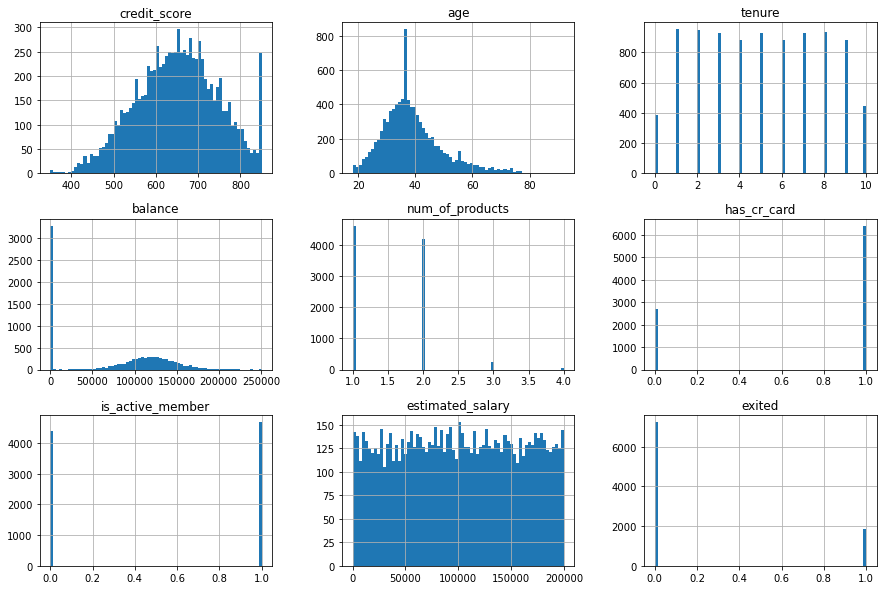

In [25]:
data.hist(bins = 70, figsize=(15, 10));

Предварительная оценка распределения значений в целевом признаке exited

In [26]:
data['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

In [27]:
print(len(data[data['exited'] == 0])/(len(data))*100,
      '% составляет значения 0 в exited относительно всего датафрейфа')

79.60620393796061 % составляет значения 0 в exited относительно всего датафрейфа


**Кодирование данных (OHE)**

Преобразовывание категориальных признаков в столбцах ('geography', 'gender') в численные с техникой прямого кодирования, или отображения (англ. One-Hot Encoding, OHE).

Прямое кодирование

In [28]:
data_ohe= pd.get_dummies(data, drop_first=True)  

In [29]:
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Необходимо все названия столбцов привести к нижнему регистру

In [30]:
data_ohe.columns= data_ohe.columns.str.lower()

Разделим выборку на целевые признаки и признаки

In [31]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

Разделение исходных данных на обучающую, валидационную и тестовую выборки. 

Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

Значит под обучающие данные мы выделим 60%. Под валидационную часть 20% и под тестовую часть тоже 20%

Выделим для начала обучающую часть и "остальную" часть в соотношении 60% и 40%

In [32]:
features_train, features_other, target_train, target_other =\
train_test_split(features, 
                 target, 
                 test_size=0.4, 
                 random_state=12345)

Разобьем оставшуюся часть на валидационную и тестовую в соотношении 50% на 50%

In [33]:
features_valid, features_test, target_valid, target_test =\
train_test_split(features_other, 
                 target_other, 
                 test_size=0.5, 
                 random_state=12345)

Выведим первые 5 стррок features_train

In [34]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8483,727,28,2,110997.76,1,1,0,101433.76,0,0,0
3431,537,26,7,106397.75,1,0,0,103563.23,0,0,1
6770,610,40,9,0.00,1,1,1,149602.54,0,0,1
1350,576,36,6,0.00,2,1,1,48314.00,0,0,1
4047,549,31,4,0.00,2,0,1,25684.85,0,0,1


**Масштабирование данных**

Стандартизируем числовые признаки

In [35]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products','estimated_salary']

In [36]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Выводы:

На выходе получили таблицу с значением 9091 строк и 11 колонок. В процессе подготовки данных скорректировали оформление у названий столбцов, удалили строки с пропусками в столбце tenure. 9.09% строк от визначального датасфрейма было удалено. Была выявлена зависимости, что строки присудствовали в равных пропорциях различных категориях и было принято решение из удлаить, так как это не приведет к резкому смещению значений во всем датафрейма.

Так же были удалены столбцы:'index','RowNumber', 'CustomerId', 'Surname'. Причина: отсутсвие полезной информации для построения модели и возможности влияние на обучение в негативную сторону.

Наблюдается неравномерное распредление данных в 'geography','num_of_products', 'has_cr_card', 'exited','balance'.
Очень сильно в 'balance'. Болшое кол-во знначений около нуля.

Столбцы с категоральными данными: 'geography','gender'. Было выполнено прямое кодирование с данным столбцами.
Также выполнено масштабирование в оставшихся числовыых столбцах.

Разделение исходных данных на обучающую, валидационную и тестовую выборки.
Исходные данные разбивают в соотношении 3:1:1.
Под обучающие данные мы выделили 60%. Под валидационную часть 20% и под тестовую часть тоже 20%


В целевом признаке exited ярко выражен дисбаланс классов. Наиболее часто всречается значение с 0 (79% составляет от всех данных в признаке)


## Исследование задачи

Рассмотрим 3 модели:

- Решающее дерево
- Случайный лес
- Логистическая регрессия

Меняя гиперпараметры каждой модели выберим наилучшую. Определять лучшую модель будем по F1 метрике

**Решающее дерево**

Обучим модель при разной глубине дерева. 

In [37]:
%%time
best_model_1 = None 

best_depth_1 = 0

best_result_accuracy_1 = 0
best_result_f1_1 = 0
best_result_roc_1 = 0

for depth in range(1, 20):
    model_1 = DecisionTreeClassifier(criterion='entropy', 
                                     max_depth=depth, 
                                     random_state=RANDOM_STATE
                                    ) 
    # обучение модели
    model_1.fit(features_train,target_train)
            
    # получение предсказания модели 
    predictions = model_1.predict(features_valid) 
            
    # подсчет Accuracy
    result_accuracy_1 = accuracy_score(target_valid, predictions)
    
    # подсчет F1
    result_f1_1 = f1_score(target_valid,predictions)
    
    # подсчет ROC
    probabilities = model_1.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    result_roc_1 = roc_auc_score(target_valid, probabilities_one)
    
             
    if result_f1_1 > best_result_f1_1:
        best_model_1 = model_1 
        best_depth_1 = depth
        best_result_accuracy_1 = result_accuracy_1
        best_result_f1_1 = result_f1_1
        best_result_roc_1 = result_roc_1
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", best_result_accuracy_1)
print('F1 мера лучшей модели::',best_result_f1_1)
print('AUC-ROC лучше модели:', best_result_roc_1)

print('')
print('Гиперпараметры:')
print("Лучшая max_depth:", best_depth_1)

Процесс завершен
Метрики:
Accuracy лучшей модели: 0.8619361936193619
F1 мера лучшей модели:: 0.5809682804674458
AUC-ROC лучше модели: 0.8449380311712504

Гиперпараметры:
Лучшая max_depth: 6
CPU times: user 407 ms, sys: 2.81 ms, total: 410 ms
Wall time: 409 ms


**Случайный лес**

In [38]:
%%time
best_model_2 = None 

best_depth_2 = 0

best_result_accuracy_2 = 0
best_result_f1_2 = 0
best_result_roc_2 = 0

best_n_estimators_2 = 0

for est in range(10, 51, 1):
    for depth in range(1, 10):
        model_2 = RandomForestClassifier(random_state=RANDOM_STATE, 
                                         n_estimators=est, 
                                         max_depth = depth) 
        # обучение модели
        
        model_2.fit(features_train,target_train)
        
        # получение предсказания модели 
        predictions = model_2.predict(features_valid) 
        
        # подсчет Accuracy
        result_accuracy_2 = accuracy_score(target_valid, predictions)
        
        # подсчет F1
        result_f1_2 = f1_score(target_valid,predictions)
        
        # подсчет ROC
        probabilities = model_2.predict_proba(features_valid)
        probabilities_one = probabilities[:, 1]
        result_roc_2 = roc_auc_score(target_valid, probabilities_one)
        
        if result_f1_2 > best_result_f1_2:
            best_model_2 = model_2 
            best_depth_2 = depth
            best_result_accuracy_2 = result_accuracy_2
            best_result_f1_2 = result_f1_2
            best_result_roc_2 = result_roc_2
            best_n_estimators_2 = est
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", best_result_accuracy_2)
print('F1 мера лучшей модели:',best_result_f1_2)
print('AUC-ROC лучше модели:', best_result_roc_2)

print('')
print('Гиперпараметры:')
print("Лучшая max_depth:", best_depth_2)
print("Лучшая n_estimators:", best_n_estimators_2)

Процесс завершен
Метрики:
Accuracy лучшей модели: 0.8657865786578658
F1 мера лучшей модели: 0.5793103448275863
AUC-ROC лучше модели: 0.8655755931354773

Гиперпараметры:
Лучшая max_depth: 8
Лучшая n_estimators: 15
CPU times: user 37.2 s, sys: 350 ms, total: 37.6 s
Wall time: 37.6 s


**Логистическая регрессия**

In [39]:
%%time
best_model_3 = None 

model_3 = LogisticRegression(random_state=RANDOM_STATE, 
                             solver='liblinear') 

# обучение модели
model_3.fit(features_train,target_train)
            
# получение предсказания модели 
predictions_3 = model_3.predict(features_valid) 
            
# подсчет Accuracy
result_accuracy_3 = accuracy_score(target_valid, predictions_3)
    
# подсчет F1
result_f1_3 = f1_score(target_valid,predictions_3)
    
# подсчет ROC
probabilities_3 = model_3.predict_proba(features_valid)
probabilities_one_3 = probabilities_3[:, 1]
result_roc_3 = roc_auc_score(target_valid, probabilities_one_3)
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", result_accuracy_3)
print('AUC-ROC лучше модели:',result_f1_3)
print('AUC-ROC:', result_roc_3)
print('')


Процесс завершен
Метрики:
Accuracy лучшей модели: 0.8085808580858086
AUC-ROC лучше модели: 0.30400000000000005
AUC-ROC: 0.7736191158144302

CPU times: user 32.7 ms, sys: 5.92 ms, total: 38.6 ms
Wall time: 34.8 ms


Выведим сводку метрик по обученным моделям

In [40]:
metriks = { 'Accuracy лучшей модели': [best_result_accuracy_1,
                                        best_result_accuracy_2,
                                        result_accuracy_3],
           'F1 мера лучшей модели': [best_result_f1_1,
                                      best_result_f1_2,
                                      result_f1_3],
           'Площадь ROC-кривой': [best_result_roc_1,
                                   best_result_roc_2,
                                   result_roc_3],

}
index_best = ['Решающее дерево:','Случайный лес','Логистическая регрессия']
pd.DataFrame(data=metriks, index=index_best)

,Accuracy лучшей модели,F1 мера лучшей модели,Площадь ROC-кривой
Решающее дерево:,0.861936,0.580968,0.844938
Случайный лес,0.865787,0.579310,0.865576
Логистическая регрессия,0.808581,0.304000,0.773619


Лучшее значение F1 мера у Решающее дерево. F1 мера = 0.580968.

Необходиом оценить на сколько хорошими получились результаты.

**Проверим модель на адекватность**

Постром гистограмму распределние целевых признаков в обучающей выборке и посмотрим на баланс классов

0    0.793546
1    0.206454
Name: exited, dtype: float64


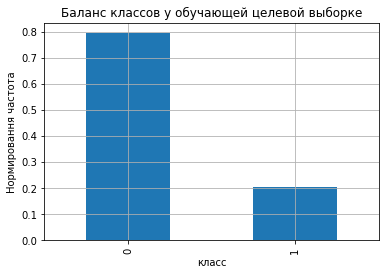

In [41]:
class_frequency = target_train.value_counts(normalize=True) 
print(class_frequency)
class_frequency.plot(kind='bar',
                    grid=True)
plt.title("Баланс классов у обучающей целевой выборке")
plt.xlabel("класс")
plt.ylabel("Нормировання частота")
plt.show()

Получаемые значения на модели больше 0.79. Это хорошо, но наблюдается дисбаланс. Нулей большей чем единиц. Необходимо оценить насколько это влият на обучение.

Рассмотрим баланс классов у целевого признака полученного при обучении модели Решающее дерево на валидационной выборке

0    0.877888
1    0.122112
dtype: float64


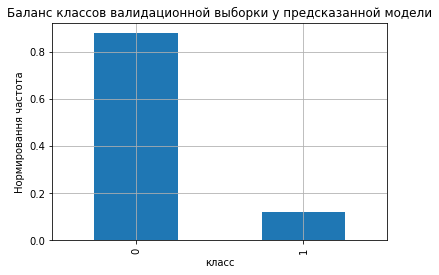

In [42]:
predicted_valid = pd.Series(best_model_1.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True) 
print(class_frequency)
class_frequency.plot(kind='bar',
                    grid=True
                    )
plt.title("Баланс классов валидационной выборки у предсказанной модели")
plt.xlabel("класс")
plt.ylabel("Нормировання частота")
plt.show()

Получаемые значения на модели на классе 0 стало поменьше. На Классе 1 повыше.. Это хорошо, но наблюдается дисбаланс. Нулей все равно большей чем единиц.

Создадим константную модель: любому объекту она прогнозирует класс «0».

In [43]:
target_pred_constant = pd.Series(0, index=target_train.index) 
print(accuracy_score(target_train, target_pred_constant))
print("Accuracy:", accuracy_score(target_train, 
                                                target_pred_constant
                                               )
     )

print('F1 мера :',f1_score(target_train,
                                         target_pred_constant
                                        )
     )

0.7935460212687936
Accuracy: 0.7935460212687936
F1 мера : 0.0


При константной модели равной нулю значение F1 меры равно 0. Не смотря на то что  Accuracy = 0.7935460212687936 и показывает хорошие значения.
Да, дисбаланс данных влияет на результат.

**Матрица ошибок**

Посчитаем матрицу ошибок на обученной модели 

In [44]:
matrix_errors = pd.DataFrame(
    confusion_matrix(target_valid,
                     best_model_1.predict(features_valid))
)
     
print(matrix_errors)

      0    1
0  1393   48
1   203  174


In [45]:
print
print('По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:')
print('TN', '-', matrix_errors[0][0])
print('TP', '-', matrix_errors[1][1])
print('Вне главной диагонали — ошибочные варианты:')
print('FP', '-', matrix_errors[0][1])
print('FN', '-', matrix_errors[1][0])

По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
TN - 1393
TP - 174
Вне главной диагонали — ошибочные варианты:
FP - 203
FN - 48


**Точность и полнота**

Матрица ошибок позволяет вычислить метрики: полноту и точность. Одако для вычисления этих метрик воспользуемся уже встроенными функциями в библиотеку sklearn.metrics

In [46]:
print('Полнота:',
      recall_score(target_valid,
                   best_model_1.predict(features_valid))
     )

Полнота: 0.46153846153846156


Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Можно наблюдать, что их меньше половины

In [47]:
print('Точность:',
      precision_score(target_valid,
                      best_model_1.predict(features_valid))
     )

Точность: 0.7837837837837838


Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные. И внашем случае точность получилась достаточно высокой

**F1-мера**

Для более точной оценки зависиомсти полноты и точности используется F1-мера

In [48]:
print('F1 мера:',
      f1_score(target_valid,
               best_model_1.predict(features_valid))
     )

F1 мера: 0.5809682804674458


**ROC-кривая и PR-кривая для Решающего дерева (не сбалансированный класс)**

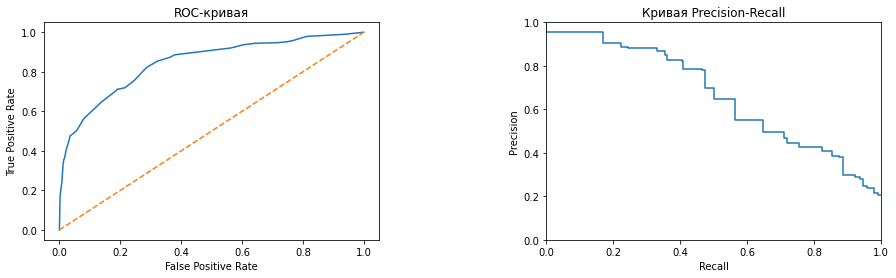

In [49]:
probabilities_valid = best_model_1.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC-кривая') 


precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_one_valid)


plt.step(recall, precision, where='post') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Кривая Precision-Recall') 
plt.show()

**Выводы:**

Был выполнен поиск наилучшй модели. Ею оказался Решающее дерево при значениях гиперпараметров:

- Лучшая max_depth: 6

Также был проведен анализ модели на адекватность и выявлено, что модель имеет дисбаланс данных в целевом признаке:

А метрики дают следующие значения: 
- Полнота: 0.46153846153846156
- Точность: 0.7837837837837838
- F1 мера: 0.5809682804674458
- AUC-ROC : 0.844938

Показатели f1 необходимо повысить.

## Борьба с дисбалансом

Посомтрим как изменится f1 метрика при class_weight='balanced' в рассматриваемых моделях обучения выше

**Решающее дерево (class_weight='balanced')**

In [50]:
%%time
best_model_1 = None 

best_depth_1 = 0

best_result_accuracy_1 = 0
best_result_f1_1 = 0
best_result_roc_1 = 0

for depth in range(1, 20):
    model_1 = DecisionTreeClassifier(criterion='entropy', 
                                     max_depth=depth, 
                                     random_state=RANDOM_STATE,
                                     class_weight='balanced'
                                    ) 
    # обучение модели
    model_1.fit(features_train,target_train)
            
    # получение предсказания модели 
    predictions = model_1.predict(features_valid) 
            
    # подсчет Accuracy
    result_accuracy_1 = accuracy_score(target_valid, predictions)
    
    # подсчет F1
    result_f1_1 = f1_score(target_valid,predictions)
    
    # подсчет ROC
    probabilities = model_1.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    result_roc_1 = roc_auc_score(target_valid, probabilities_one)
    
             
    if result_f1_1 > best_result_f1_1:
        best_model_1 = model_1 
        best_depth_1 = depth
        best_result_accuracy_1 = result_accuracy_1
        best_result_f1_1 = result_f1_1
        best_result_roc_1 = result_roc_1
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", best_result_accuracy_1)
print('F1 мера лучшей модели::',best_result_f1_1)
print('AUC-ROC лучше модели:', best_result_roc_1)

print('')
print('Гиперпараметры:')
print("Лучшая max_depth:", best_depth_1)

Процесс завершен
Метрики:
Accuracy лучшей модели: 0.7568756875687569
F1 мера лучшей модели:: 0.5666666666666667
AUC-ROC лучше модели: 0.847368740761739

Гиперпараметры:
Лучшая max_depth: 5
CPU times: user 441 ms, sys: 3.53 ms, total: 445 ms
Wall time: 443 ms


**Случайный лес  (class_weight='balanced')**

In [51]:
%%time
best_model_2 = None 

best_depth_2 = 0

best_result_accuracy_2 = 0
best_result_f1_2 = 0
best_result_roc_2 = 0

best_n_estimators_2 = 0

for est in range(10, 51, 5):
    for depth in range(1, 10):
        model_2 = RandomForestClassifier(random_state=RANDOM_STATE, 
                                         n_estimators=est, 
                                         max_depth = depth,
                                        class_weight='balanced') 
        # обучение модели
        
        model_2.fit(features_train,target_train)
        
        # получение предсказания модели 
        predictions = model_2.predict(features_valid) 
        
        # подсчет Accuracy
        result_accuracy_2 = accuracy_score(target_valid, predictions)
        
        # подсчет F1
        result_f1_2 = f1_score(target_valid,predictions)
        
        # подсчет ROC
        probabilities = model_2.predict_proba(features_valid)
        probabilities_one = probabilities[:, 1]
        result_roc_2 = roc_auc_score(target_valid, probabilities_one)
        
        if result_f1_2 > best_result_f1_2:
            best_model_2 = model_2 
            best_depth_2 = depth
            best_result_accuracy_2 = result_accuracy_2
            best_result_f1_2 = result_f1_2
            best_result_roc_2 = result_roc_2
            best_n_estimators_2 = est
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", best_result_accuracy_2)
print('F1 мера лучшей модели:',best_result_f1_2)
print('AUC-ROC лучше модели:', best_result_roc_2)

print('')
print('Гиперпараметры:')
print("Лучшая max_depth:", best_depth_2)
print("Лучшая n_estimators:", best_n_estimators_2)

Процесс завершен
Метрики:
Accuracy лучшей модели: 0.8443344334433444
F1 мера лучшей модели: 0.6466916354556803
AUC-ROC лучше модели: 0.8665861645593155

Гиперпараметры:
Лучшая max_depth: 9
Лучшая n_estimators: 45
CPU times: user 7.78 s, sys: 67.1 ms, total: 7.85 s
Wall time: 7.85 s


**Линейная регрессия (class_weight='balanced')**

In [52]:
%%time
best_model_3 = None 

model_3 = LogisticRegression(random_state=RANDOM_STATE, 
                             solver='liblinear',
                            class_weight='balanced') 

# обучение модели
model_3.fit(features_train,target_train)
            
# получение предсказания модели 
predictions_3 = model_3.predict(features_valid) 
            
# подсчет Accuracy
result_accuracy_3 = accuracy_score(target_valid, predictions_3)
    
# подсчет F1
result_f1_3 = f1_score(target_valid,predictions_3)
    
# подсчет ROC
probabilities_3 = model_3.predict_proba(features_valid)
probabilities_one_3 = probabilities_3[:, 1]
result_roc_3 = roc_auc_score(target_valid, probabilities_one_3)
                
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", result_accuracy_3)
print('AUC-ROC лучше модели:',result_f1_3)
print('AUC-ROC:', result_roc_3)
print('')

Процесс завершен
Метрики:
Accuracy лучшей модели: 0.7090209020902091
AUC-ROC лучше модели: 0.509731232622799
AUC-ROC: 0.7777884132187896

CPU times: user 17.5 ms, sys: 2.84 ms, total: 20.4 ms
Wall time: 17.8 ms


Выведим сводку метрик по обученным моделям

In [53]:
metriks_1 = { 'Accuracy лучшей модели': [best_result_accuracy_1,
                                        best_result_accuracy_2,
                                        result_accuracy_3],
           'F1 мера лучшей модели': [best_result_f1_1,
                                      best_result_f1_2,
                                      result_f1_3],
           'Площадь ROC-кривой': [best_result_roc_1,
                                   best_result_roc_2,
                                   result_roc_3],

}
index_best_1 = ['Решающее дерево:','Случайный лес','Логистическая регрессия']
pd.DataFrame(data=metriks_1, index=index_best_1)

,Accuracy лучшей модели,F1 мера лучшей модели,Площадь ROC-кривой
Решающее дерево:,0.756876,0.566667,0.847369
Случайный лес,0.844334,0.646692,0.866586
Логистическая регрессия,0.709021,0.509731,0.777788


Модель случайный лес показала себя лучше. выберем ее для дальнейших исследований

**ROC-кривая и PR-кривая для Случайного леса (class_weight='balanced')**

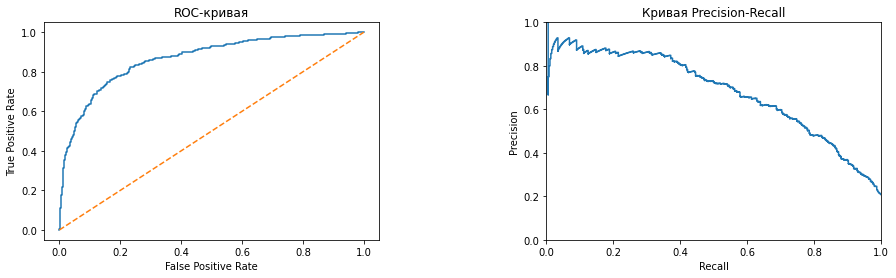

In [54]:
probabilities_valid = best_model_2.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC-кривая') 


precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_one_valid)


plt.step(recall, precision, where='post') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Кривая Precision-Recall') 
plt.show()

In [55]:
print('Полнота:',
      recall_score(target_valid,
                   best_model_2.predict(features_valid))
     )
print('Точность:',
      precision_score(target_valid,
                      best_model_2.predict(features_valid))
     )


Полнота: 0.6870026525198939
Точность: 0.6108490566037735


Метрика AUC-ROC показыввает хороший результат. 

**Увеличение выборки**

Рассмтрим еще один способ, который нам поможет поднять показатели. Борьбу с дисбалансом будем выолнять за счет увеличение выборки

In [56]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # < добавляем перемешивание >
    features_upsampled = shuffle(features_upsampled, random_state=12345) 
    target_upsampled = shuffle(target_upsampled, random_state=12345) 
    return features_upsampled, target_upsampled

In [57]:
repeat = round(len(target_train[target_train == 0])/len(target_train[target_train == 1]))

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

Проверим, что баланс классов выполнен

Text(0.5, 0, 'Классы')

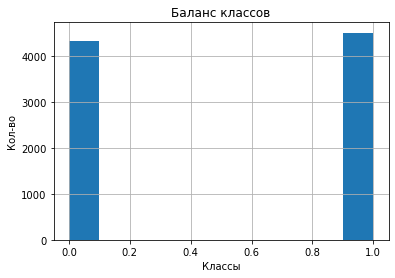

In [58]:
target_upsampled.hist()
plt.title('Баланс классов')
plt.ylabel('Кол-во')
plt.xlabel('Классы')

In [59]:
%%time
best_model_upsampled = None 
best_result_upsampled = 0
best_depth_upsampled = 0

best_depth_upsampled = 0

best_result_accuracy_upsampled = 0
best_result_f1_upsampled = 0
best_result_roc_upsampled = 0

best_n_estimators_upsampled = 0

for est in range(10, 51, 5):
    for depth in range(1, 10):
        model_upsampled = RandomForestClassifier(random_state=RANDOM_STATE, 
                                         n_estimators=est, 
                                         max_depth = depth) 
        # обучение модели
        
        model_upsampled.fit(features_upsampled,target_upsampled)
        
        # получение предсказания модели 
        predictions = model_upsampled.predict(features_valid) 
        
        # подсчет Accuracy
        result_accuracy_upsampled = accuracy_score(target_valid, predictions)
        
        # подсчет F1
        result_f1_upsampled = f1_score(target_valid,predictions)
        
        # подсчет ROC
        probabilities = model_upsampled.predict_proba(features_valid)
        probabilities_one = probabilities[:, 1]
        result_roc_upsampled = roc_auc_score(target_valid, probabilities_one)
        
        if result_f1_upsampled > best_result_f1_upsampled:
            best_model_upsampled = model_upsampled 
            best_depth_upsampled = depth
            best_result_accuracy_upsampled = result_accuracy_upsampled
            best_result_f1_upsampled = result_f1_upsampled
            best_result_roc_upsampled = result_roc_upsampled
            best_n_estimators_upsampled = est
                
print('')
print('Процесс завершен')  
print('Метрики:')
print("Accuracy лучшей модели:", best_result_accuracy_upsampled)
print('F1 мера лучшей модели:',best_result_f1_upsampled)
print('AUC-ROC лучше модели:', best_result_roc_upsampled)
print('')
print('Гиперпараметры:')
print("Лучшая max_depth:", best_depth_upsampled)
print("Лучшая n_estimators:", best_n_estimators_upsampled)
print('')


Процесс завершен
Метрики:
Accuracy лучшей модели: 0.8135313531353136
F1 мера лучшей модели: 0.6262403528114664
AUC-ROC лучше модели: 0.8681784127954173

Гиперпараметры:
Лучшая max_depth: 8
Лучшая n_estimators: 25

CPU times: user 10.1 s, sys: 98.7 ms, total: 10.2 s
Wall time: 10.2 s


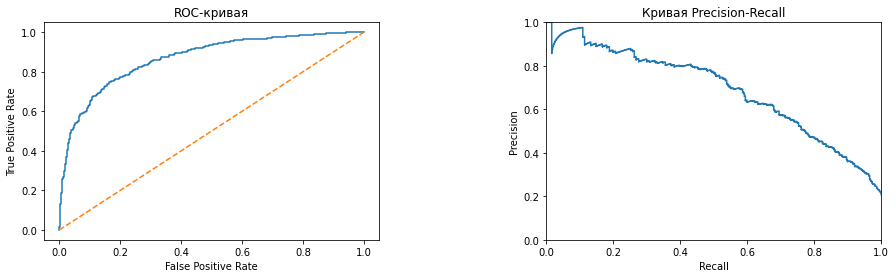

In [60]:
probabilities_valid = best_model_upsampled.predict_proba(features_valid) 
probabilities_one_valid = probabilities_valid[:, 1]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC-кривая') 


precision, recall, thresholds = precision_recall_curve(target_valid,
                                                       probabilities_one_valid)


plt.step(recall, precision, where='post') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Кривая Precision-Recall') 
plt.show()

In [61]:
print('Полнота:',
      recall_score(target_valid,
                   best_model_upsampled.predict(features_valid))
     )
print('Точность:',
      precision_score(target_valid,
                      best_model_upsampled.predict(features_valid))
     )

print('AUC-ROC:',roc_auc_score(target_valid, probabilities_one_valid))

Полнота: 0.753315649867374
Точность: 0.5358490566037736
AUC-ROC: 0.8681784127954173


Выведим сравнение метрик по

In [62]:
metriks_2 = { 'Accuracy лучшей модели': [best_result_accuracy_2,
                                        best_result_accuracy_upsampled],
           'F1 мера лучшей модели': [best_result_f1_2,
                                      best_result_f1_upsampled],
           'Площадь ROC-кривой': [best_result_roc_2,
                                   best_result_roc_upsampled],

}
index_best_2 = ['Случайный лес (class_weight=balanced)','Случайный лес (увеличение выборки)']
pd.DataFrame(data=metriks_2, index=index_best_2).T

,Случайный лес (class_weight=balanced),Случайный лес (увеличение выборки)
Accuracy лучшей модели,0.844334,0.813531
F1 мера лучшей модели,0.646692,0.626240
Площадь ROC-кривой,0.866586,0.868178


**Выводы**

Было 2 способа борьбы способы с дисбалансом:
- 1) применив class_weight='balanced' в моеделях: Дерево решений, Случайный лес, Линейная регрессия.

| Метрики             | Дерево решений           |  Случайны лес       |  Линейная регрессия  |  
| :---               | :----                   | :----            | :----                  |  
|  Accuary           |     0.7871287128712872           |0.8443344334433444                |0.7090209020902091               |
| F1                 |       0.5420118343195266         |0.6466916354556803                 |0.5004721435316335               |
| Полнота (recall)    |       -         |0.6870026525198939                |-              |
| Точность (precision)|      -          |0.6108490566037735          |-               |
| AUC-ROC            |      -         |0.8665861645593155               | -              |
 


Лучшей оказалась модель случайного леса по параметрам F1

Гиперпараметры:
- Лучшая max_depth: 9
- Лучшая n_estimators: 45


- 2) увеличение выборки. Рассмотрено на модели случайны лес. 


| Метрики             | Случайный лес (class_weight=balanced)          |Случайный лес (увеличение выборки) |
| :---                | :----                           |:----                            |
|  Accuary            |     0.844334         |     0.813531          |
| F1                  |       0.646692        |     0.626240         |
| Полнота (recall)    |       0.866586         |     0.868178          |
| Точность (precision)|      0.6870026525198939         |     0.753315649867374         |
| AUC-ROC             |      0.6108490566037735         |     0.5358490566037736          |



Таким образом,исправление дисбаланса классов в target_train повысило качетво модели.

Гиперпараметры:
- Лучшая max_depth: 8
- Лучшая n_estimators: 25

Проведем тестирование модели. Тестирование Будем проводить на модели Случайны лес применив class_weight='balanced' и с гиперпараметрами:
- Лучшая max_depth: 9
- Лучшая n_estimators: 45
Так как значение f1 метрики у нее  оказалось выше.

## Тестирование модели

Проведем тестирование на модели Случайный лес (class_weight='balanced')

In [63]:
predictions_test_1 = best_model_2.predict(features_test) 

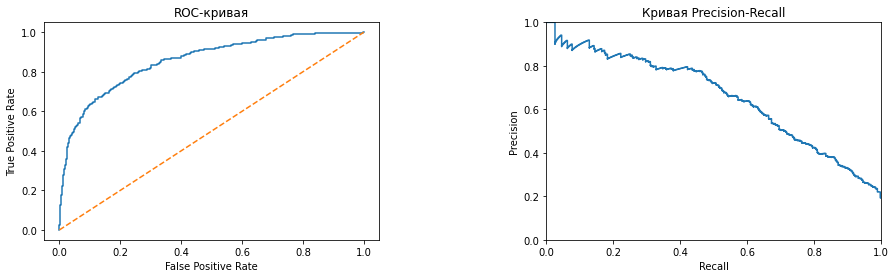

In [64]:
probabilities_test = best_model_2.predict_proba(features_test) 
probabilities_one_test = probabilities_test[:, 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC-кривая') 


precision, recall, thresholds = precision_recall_curve(target_test,
                                                       probabilities_one_test)


plt.step(recall, precision, where='post') 
plt.ylim([0.0, 1.0]) 
plt.xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Кривая Precision-Recall') 
plt.show()

In [69]:
print("Accuracy наилучшей модели на тестовой выборке:", accuracy_score(target_test, predictions_test_1))
print('F1 мера наилучшей модели на тестовой выборке:', f1_score(target_test,predictions_test_1))
print('Полнота наилучшей модели на тестовой выборке:', recall_score(target_test,predictions_test_1))
print('Точность наилучшей модели на тестовой выборке:', precision_score(target_test, predictions_test_1))
print('AUC-ROC наилучшей модели на тестовой выборке:',roc_auc_score(target_test, probabilities_one_test))


Accuracy наилучшей модели на тестовой выборке: 0.8416712479384277
F1 мера наилучшей модели на тестовой выборке: 0.6118598382749326
Полнота наилучшей модели на тестовой выборке: 0.6467236467236467
Точность наилучшей модели на тестовой выборке: 0.5805626598465473
AUC-ROC наилучшей модели на тестовой выборке: 0.8563388372652678


Вывод:

На тестовой выборке получились следующе значения:


| Метрики             | class_weight='balanced'          |  
| :---               | :----                   | 
|  Accuary           |     0.8416712479384277           |      
| F1                 |       0.6118598382749326        |
| Полнота (recall)    |       0.6467236467236467         |
| Точность (precision)|      0.5805626598465473          |
| AUC-ROC            |      0.8563388372652678         | 


Необходимое качество f1 выше 0.59 достигли.


## Итоговый вывод 

**Общий вывод**

Представлены данные из банка. 
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Необходимо построить модель с предельно большим значением F1-меры (до 0.59).
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.


* **Шаг 1**

На выходе получили таблицу с значением 9091 строк и 11 колонок. В процессе подготовки данных скорректировали оформление у названий столбцов, удалили строки с пропусками в столбце tenure. 9.09% строк от визначального датасфрейма было удалено. Была выявлена зависимости, что строки присудствовали в равных пропорциях различных категориях и было принято решение из удлаить, так как это не приведет к резкому смещению значений во всем датафрейма.

Так же были удалены столбцы:'index','RowNumber', 'CustomerId', 'Surname'. Причина: отсутсвие полезной информации для построения модели и возможности влияние на обучение в негативную сторону.

Наблюдается неравномерное распредление данных в 'geography','num_of_products', 'has_cr_card', 'exited','balance'.
Очень сильно в 'balance'. Болшое кол-во знначений около нуля.

Столбцы с категоральными данными: 'geography','gender'. Было выполнено прямое кодирование с данным столбцами.
Также выполнено масштабирование в оставшихся числовыых столбцах.

Разделение исходных данных на обучающую, валидационную и тестовую выборки.
Исходные данные разбивают в соотношении 3:1:1.
Под обучающие данные мы выделили 60%. Под валидационную часть 20% и под тестовую часть тоже 20%


В целевом признаке exited ярко выражен дисбаланс классов. Наиболее часто всречается значение с 0 (79% составляет от всех данных в признаке)

* **Шаг 2**

Был выполнен поиск наилучшй модели. Ею оказался Решающее дерево при значениях гиперпараметров:

- Лучшая max_depth: 6

Также был проведен анализ модели на адекватность и выявлено, что модель имеет дисбаланс данных в целевом признаке

А метрики дают следующие значения: 
- Полнота: 0.46153846153846156
- Точность: 0.7837837837837838
- F1 мера: 0.5809682804674458
- AUC-ROC : 0.844938

Т.к. точность определяет, как много отрицательных ответов нашла модель, пока искала положительные. И внашем случае точность получилоь достаточно высокой
Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Можно наблюдать, что их меньше половины. 

Показатели f1 необходимо повысить.


* **Шаг 3**

Было 2 способа борьбы способы с дисбалансом:
- 1) применив class_weight='balanced' в моеделях: Дерево решений, Случайный лес, Линейная регрессия.

| Метрики             | Дерево решений           |  Случайны лес       |  Линейная регрессия  |  
| :---               | :----                   | :----            | :----                  |  
|  Accuary           |     0.7871287128712872           |0.8443344334433444                |0.7090209020902091               |
| F1                 |       0.5420118343195266         |0.6466916354556803                 |0.5004721435316335               |
| Полнота (recall)    |       -         |0.6870026525198939                |-              |
| Точность (precision)|      -          |0.6108490566037735          |-               |
| AUC-ROC            |      -         |0.8665861645593155               | -              |
 


Лучшей оказалась модель случайного леса по параметрам F1

Гиперпараметры:
- Лучшая max_depth: 9
- Лучшая n_estimators: 45


- 2) увеличение выборки. Рассмотрено на модели случайны лес. 


| Метрики             | Случайный лес (class_weight=balanced)          |Случайный лес (увеличение выборки) |
| :---                | :----                           |:----                            |
|  Accuary            |     0.844334         |     0.813531          |
| F1                  |       0.646692        |     0.626240         |
| Полнота (recall)    |       0.866586         |     0.868178          |
| Точность (precision)|      0.6870026525198939         |     0.753315649867374         |
| AUC-ROC             |      0.6108490566037735         |     0.5358490566037736          |



Таким образом,исправление дисбаланса классов в target_train повысило качетво модели.

Гиперпараметры:
- Лучшая max_depth: 8
- Лучшая n_estimators: 25

Проведем тестирование модели. Тестирование Будем проводить на модели Случайны лес применив class_weight='balanced' и с гиперпараметрами:
- Лучшая max_depth: 9
- Лучшая n_estimators: 45
Так как значение f1 метрики у нее  оказалось выше.

* **Шаг 4**

На тестовой выборке получились следующе значения:


| Метрики             | class_weight='balanced'          |  
| :---               | :----                   | 
|  Accuary           |     0.8416712479384277           |      
| F1                 |       0.6118598382749326        |
| Полнота (recall)    |       0.6467236467236467         |
| Точность (precision)|      0.5805626598465473          |
| AUC-ROC            |      0.8563388372652678         | 


Таким образом модель случанйый лес дает необходиоме значение F1 выше 0,59 с борьбой диссбаланса с помощью  class_weight='balanced' и с гиперпараметрами:
- Лучшая max_depth: 9
- Лучшая n_estimators: 45

